# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 2

We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 0cf2052e


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving prompt_best_practices.pdf to prompt_best_practices.pdf


In [6]:
file_path = list(uploaded.keys())[0]
file_path

'prompt_best_practices.pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

By setting up a cache for vector embeddings, you can avoid redundant conversions by checking if a document has already been processed. This saves time and costs, especially for repeated or similar content. However, managing the cache, handling model updates, saving in local db with memory constraint, and ensuring efficiency for unique inputs are key challenges. In the right use case, this approach can streamline operations significantly.

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [17]:
docs[1].page_content

'https://github.com/VILA-Lab/ATLAS.\n1\nIntroduction\n“\nPrompt engineering is the art of communicating with a generative\nlarge language model.\n”\nChatGPT, 2023\nLarge language models (LLMs) like ChatGPT [13] have shown impressive abilities\nin various domains and tasks, such as answering questions [7], mathematical reason-\ning [5], code generating [11, 9], etc. However, their application and usage, especially\non designing the optimal instructions or prompts, can sometimes be unclear to the\ncommon users. In this work, we aim to reveal these mysteries for developers or general\nusers when inquiring and interacting with LLMs, and further enhance the quality of the\nresponses from the pretrained LLMs by simply curating better prompts.\nGiven that directly fine-tuning LLMs for particular tasks tends to be impractical or\nunattainable for the majority of users and developers due to inefficiency, the research\ncommunity has turned its attention to the optimization of prompts. The techni

In [36]:
### YOUR CODE HERE

import time

cache = {}

def get_embedding(text):
    if text in cache:
        return cache[text]
    else:
        time.sleep(1)  # Simulate processing delay
        embedding = f"vector_{hash(text)}"
        cache[text] = embedding
        return embedding

# Measure time for first call (without cache)
start = time.time()
get_embedding(docs[1].page_content)
print(f"First call (no cache): {(time.time() - start) * 1000:.2f} ms")

# Measure time for second call (with cache)
start = time.time()
get_embedding(docs[1].page_content)
print(f"Second call (no cache): {(time.time() - start) * 1000:.2f} ms")

First call (no cache): 1002.13 ms
Second call (no cache): 0.10 ms


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [31]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [39]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [40]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

Using a prompt cache can save time and money by reusing responses for prompts we've seen before, but it has its downsides. If the model gets updated or the context changes, the cached response might not be relevant anymore. This works best when you're dealing with repetitive or predictable prompts, but it’s less useful when you need fresh, real-time answers that depend on the latest context.

> NOTE: There is no single correct answer here!

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [38]:
from langchain.schema import HumanMessage

# Define the prompt
prompt = "Write 10 things about this document!"

# Measure time for first call (without cache)
start_time = time.time()
response1 = chat_model([HumanMessage(content=prompt)])
time_without_cache = (time.time() - start_time) * 1000  # Convert to milliseconds
print(f"First call (no cache): {time_without_cache:.2f} ms")
print(f"Response: {response1.content}\n")

# Measure time for second call (with cache)
start_time = time.time()
response2 = chat_model([HumanMessage(content=prompt)])
time_with_cache = (time.time() - start_time) * 1000  # Convert to milliseconds
print(f"Second call (with cache): {time_with_cache:.2f} ms")
print(f"Response: {response2.content}\n")

# Calculate performance improvement
improvement = time_without_cache - time_with_cache
print(f"Time saved with cache: {improvement:.2f} ms")

<ipython-input-38-2c6226439132>:8: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response1 = chat_model([HumanMessage(content=prompt)])


First call (no cache): 1012.93 ms
Response: Sure! However, I need to have the document or some details about it in order to help you. Please provide the content or key points from the document, and I’ll be happy to summarize or extract information from it!

Second call (with cache): 1.59 ms
Response: Sure! However, I need to have the document or some details about it in order to help you. Please provide the content or key points from the document, and I’ll be happy to summarize or extract information from it!

Time saved with cache: 1011.34 ms


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [34]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [35]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "prompt_best_practices.pdf."\n2. It consists of 24 pages in total.\n3. The document was created on December 27, 2023.\n4. It was last modified on the same date.\n5. The document is formatted as PDF 1.5.\n6. It was produced using pdfTeX-1.40.25.\n7. The document contains metadata indicating the source as \'source_21.\'\n8. The structure of the document includes multiple sections, each focusing on different aspects of prompt principles.\n9. Page 4 highlights the importance of clearly stating model requirements for content production.\n10. It emphasizes the use of keywords, regulations, hints, or instructions.\n11. The document provides guidelines for writing texts similar to provided samples.\n12. It suggests using the same language as the source material for consistency.\n13. There is a reference to "Table 1," which summarizes 26 prompt principles.\n14. Page 19 lists a number of contributors or authors associated with the document.\n15. It in

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

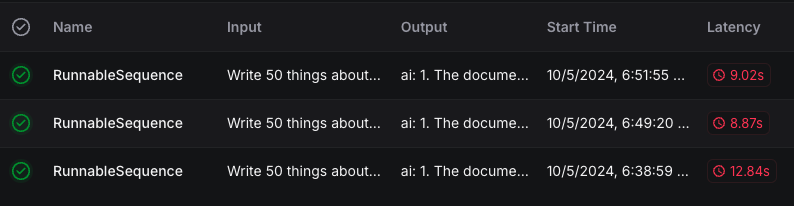

The first invoke of 12.84 seconds is without caching of the prompt. There was a modest gain in second call that is contributed to searching the cache for same prompt and returning the response without hitting OpenAI. There modest difference suggests that maybe the cache did not work correctly. However, I understand the general concept through this exercise.